In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Generate a dataset that we will use here.

In [ ]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(50)
y = np.sin(X) + 0.1 * rng.randn(50)
# Need to make X two-dimensional so that each data point is a row
X = X[:, np.newaxis]
# Make y a column vector
y = y[:, np.newaxis]

**Linear Regression**

We first implement ridge regression (linear regression with l_2 regularization).

In [ ]:
class RidgeRegression(object):
    def __init__(self, lambda_=0):
        self.lambda_ = lambda_
        self.theta = None
    
    def fit(self, X, y):
        # Prepend 1 in front of each data point
        X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
        identity_no_bias = np.identity(X.shape[1])
        identity_no_bias[0, 0] = 0
        self.theta = np.linalg.pinv(np.transpose(X) @ X + self.lambda_ * identity_no_bias) @ np.transpose(X) @ y
    
    def predict(self, X):
        # Prepend 1 in front of each data point
        X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
        return X @ self.theta

We then see if linear regression (equivalent to ridge regression with lambda = 0) works very well for fitting our data.

In [ ]:
# Note that ridge regression with lambda = 0 is identical to standard linear regression
lin_reg = RidgeRegression(lambda_=0)
lin_reg.fit(X, y)
y_hat = lin_reg.predict(X)

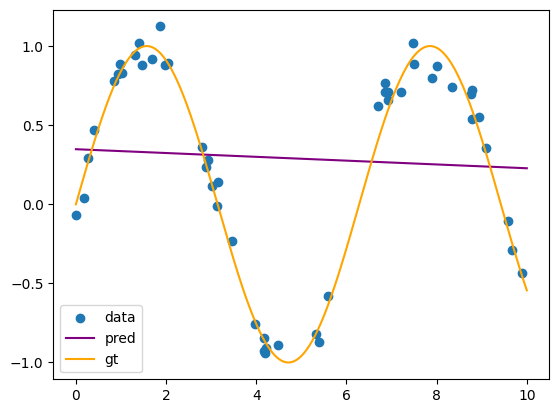

In [ ]:
plt.scatter(X[:, 0], y[:, 0], label='data')
X_test = np.linspace(0, 10, 1000)
y_test_hat = lin_reg.predict(X_test[:, np.newaxis])[:, 0]
plt.plot(X_test, y_test_hat, label='pred', color='purple')
plt.plot(X_test, np.sin(X_test), label='gt', color='orange')
plt.legend()

**Linear Regression with Gaussian Basis Functions**

From the graph above, we see that standard linear regression underfits. Let's try using Gaussian basis functions with linear regression.

In [ ]:
class GaussianFeatures(object):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, sigma_factor=2.0):
        self.N = N
        self.sigma_factor = sigma_factor
        # create N means spread along the data range
        self.mu_ = np.linspace(0, 10, self.N)
        self.sigma_ = self.sigma_factor * (self.mu_[1] - self.mu_[0])
    
    @staticmethod
    def _gauss_basis(x, y, sigma, axis=None):
        arg = (x - y) / sigma
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.mu_,
                                 self.sigma_, axis=1)

In [ ]:
gauss_feat = GaussianFeatures(30)
Phi = gauss_feat.transform(X)
lin_reg = RidgeRegression(lambda_ = 0)
lin_reg.fit(Phi, y)

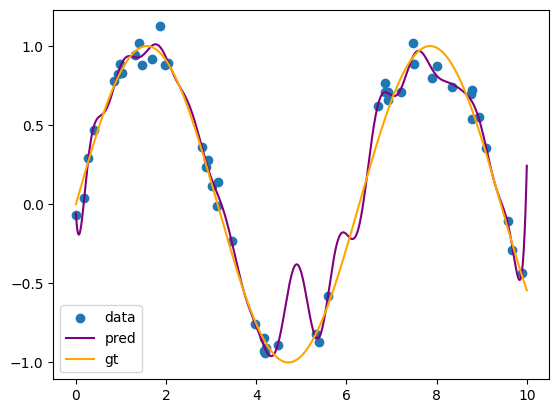

In [ ]:
plt.scatter(X[:, 0], y[:, 0], label='data')
X_test = np.linspace(0, 10, 1000)
Phi_test = gauss_feat.transform(X_test[:, np.newaxis])
y_test_hat = lin_reg.predict(Phi_test)[:, 0]
plt.plot(X_test, y_test_hat, label='pred', color='purple')
plt.plot(X_test, np.sin(X_test), label='gt', color='orange')
plt.legend()

**Cross-Validation with Ridge Regression**

We observe that using Gaussian basis features improves the model's performance. However, the model now overfits. To help resolve this overfitting, we will apply l_2 regularization to linear regression (i.e. ridge regression) using Gaussian basis features as input.

However, we have an important hyperparameter: the lambda for the regularization term. To set this hyperparameter, we will use cross-validation.

In [ ]:
gauss_feat = GaussianFeatures(30)
Phi = gauss_feat.transform(X)

In [ ]:
def mse(y, yhat):
    return np.mean((y - yhat) ** 2)

In [ ]:
def cross_validation(model, X, y, num_folds=10):
    mse_list = []
    # Seed so that all cross-validation runs will use same random folds
    np.random.seed(0)
    # Randomly permute X and y so that folds will be random disjoint subsets
    random_indices = np.random.permutation(X.shape[0])
    X, y = X[random_indices], y[random_indices]
    # Loop through each fold
    for i in range(num_folds):
       val_start_index, val_end_index = int(i * X.shape[0] / num_folds), min(int((i + 1) * X.shape[0] / num_folds), X.shape[0])
       val_indices = list(range(val_start_index, val_end_index))
       train_indices = list(range(val_start_index)) + list(range(val_end_index, X.shape[0]))
       X_val, y_val = X[val_indices], y[val_indices]
       X_train, y_train = X[train_indices], y[train_indices]

       model.fit(X_train, y_train)
       y_val_hat = model.predict(X_val)
       mse_val = mse(y_val, y_val_hat)
       mse_list.append(mse_val)
    return np.mean(mse_list)

In [ ]:
lambda_list = [0.0, 0.1, 1.0, 10.0]
ridge_reg_model_list = [RidgeRegression(lambda_) for lambda_ in lambda_list]

In [ ]:
best_lambda = -1
min_cv_mse = np.inf
for ridge_reg_model in ridge_reg_model_list:
    cv_mse = cross_validation(ridge_reg_model, np.array(Phi), y, 10)
    print(f'Cross-Validation Loss for lambda={ridge_reg_model.lambda_}: {cv_mse}')
    if cv_mse < min_cv_mse:
        min_cv_mse = cv_mse
        best_lambda = ridge_reg_model.lambda_
print(f'Best lambda: {best_lambda}')

Cross-Validation Loss for lambda=0.0: 0.5009644575250529
Cross-Validation Loss for lambda=0.1: 0.007939074887149237
Cross-Validation Loss for lambda=1.0: 0.012665322403533342
Cross-Validation Loss for lambda=10.0: 0.07065373409704234
Best lambda: 0.1


Now that we've determined the best lambda, we can train a model with this lambda value on the whole training dataset.

In [ ]:
ridge_reg = RidgeRegression(lambda_ = best_lambda)
ridge_reg.fit(Phi, y)

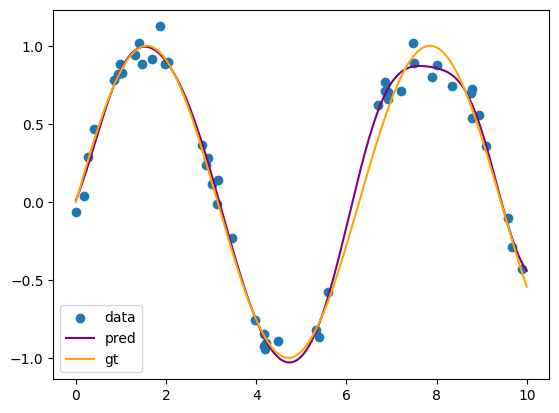

In [ ]:
plt.scatter(X[:, 0], y[:, 0], label='data')
X_test = np.linspace(0, 10, 1000)
Phi_test = gauss_feat.transform(X_test[:, np.newaxis])
y_test_hat = ridge_reg.predict(Phi_test)[:, 0]
plt.plot(X_test, y_test_hat, label='pred', color='purple')
plt.plot(X_test, np.sin(X_test), label='gt', color='orange')
plt.legend()